In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# set up font for plotting

from matplotlib import rc, font_manager

font_files = font_manager.findSystemFonts(fontpaths="/Users/Paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

In [3]:
# load dataset spreadsheet

df = pd.read_csv("./review_spreadsheets/datasets.csv")
df

,data_name,purpose_type,purpose_tags,purpose_stated,purpose_llmdev,entries_type,entries_languages,entries_n,entries_unit,entries_detail,...,access_hf_url,access_license,publication_date,publication_affils,publication_sector,publication_name,publication_venue,publication_url,other_notes,other_date_added
0,RuLES,narrow safety,rule-following,evaluate the ability of LLMs to follow simple ...,eval only,chat,English,862,prompts,Each prompt is a test case combining rules and...,...,https://huggingface.co/datasets/normster/RuLES,Apache 2.0,8-Mar-2024,"UC Berkeley, Center for AI Safety, Stanford, K...",academia / npo,"Mu et al.: ""Can LLMs Follow Simple Rules?""",arxiv,https://arxiv.org/abs/2311.04235,- covers 19 rules across 14 scenarios,11.01.2024
1,HarmBench,broad safety,"used to test adversarial method,",evaluate effectiveness of automated red-teamin...,eval only,chat,English,400,prompts,Each prompt is an instruction.,...,not available,MIT,27-Feb-2024,"University of Illinois, Center for AI Safety, ...",mixed,"Mazeika et al.: ""HarmBench: A Standardized Eva...",arxiv,https://arxiv.org/abs/2402.04249,- covers 7 semantic categories of behaviour: C...,NaN
2,DecodingTrust,broad safety,benchmark,evaluate trustworthiness of LLMs,eval only,multiple choice,English,"243,877",prompts,Each prompt is an instruction.,...,https://huggingface.co/datasets/AI-Secure/Deco...,CC BY-SA 4.0,26-Feb-2024,"University of Illinois, Stanford University, U...",mixed,"Wang et al.: ""DecodingTrust: A Comprehensive A...",NeurIPS 2023 (Outstanding Paper),https://arxiv.org/abs/2306.11698,- split across 8 'trustworthiness perspectives...,11.01.2024
3,SimpleSafetyTests,broad safety,NaN,evaluate critical safety risks in LLMs,eval only,chat,English,100,prompts,Each prompt is a simple question or instruction.,...,https://huggingface.co/datasets/Bertievidgen/S...,CC BY-NC 4.0,16-Feb-2024,"Patronus AI, University of Oxford, Bocconi Uni...",mixed,"Vidgen et al.: ""SimpleSafetyTests: a Test Suit...",arxiv,https://arxiv.org/abs/2311.08370,- split into ten types of prompts,23.12.2023
4,StrongREJECT,broad safety,used to test adversarial method,better investigate the effectiveness of differ...,eval only,chat,English,346,prompts,Each prompt is a 'forbidden question' in one o...,...,not available,unspecified,15-Feb-2024,UC Berkeley,academia / npo,"Souly et al.: ""A StrongREJECT for Empty Jailbr...",arxiv,https://arxiv.org/pdf/2402.10260.pdf,- focus of the work is adversarial / to jailbr...,27.02.2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Regard,bias,sociodemographics,evaluate biases in natural language generation,eval only,autocomplete,English,60,prompts,Each prompt is an unfinished sentence.,...,not available,unspecified,3-Nov-2019,"USC, UCLA",academia / npo,"Sheng et al.: ""The Woman Worked as a Babysitte...",EMNLP 2019,https://aclanthology.org/D19-1339,"- covers 3 categories of bias: binary gender, ...",NaN
98,ParlAIDialogueSafety,broad safety,adversarial goal in data creation,evaluate and improve the safety of conversatio...,train and eval,chat,English,"90,000",prompts,"30k are for multi-turn tasks, and 60k for sing...",...,not available,MIT,3-Nov-2019,"Facebook AI Research, Virginia Tech",mixed,"Dinan et al.: ""Build it Break it Fix it for Di...",EMNLP 2019,https://aclanthology.org/D19-1461,"- download only via ParlAI\n- the ""single-turn...",23.12.2023
99,EmpatheticDialogues,broad safety,positive interaction,train dialogue agents to be more empathetic,train only,chat,English,"24,850",conversations,Each conversation is about an emotional situat...,...,not available,CC BY-NC 4.0,28-Jul-2019,Facebook AI Research,industry,"Rashkin et al.: ""Towards Empathetic Open-domai...",ACL 2019,https://aclanthology.org/P19-1534,- 810 crowdworkers participated in dataset cre...,NaN
100,WinoBias,bias,gender,evaluate gender bias in coreference resolution,eval only,other,English,"3,160",sentences,Each sentence refers to a person by their occ

In [4]:
# process columns

# date to year
df["publication_year"] = pd.to_datetime(df["publication_date"]).dt.year

# publication affils: parse string list of affiliations into Python list
df["publication_affils"] = df["publication_affils"].str.split(", ")

# entries_languages: parse string list of affiliations into Python list
df["entries_languages"] = df["entries_languages"].str.split(", ")

In [5]:
# describe access_license

# license types
license_types = {
    "MIT": "MIT",
    "Apache 2.0": "Apache 2.0",
    "CC BY 4.0": "CC BY* 4.0",
    "CC BY-SA 4.0": "CC BY* 4.0",
    "CC BY-NC-SA 4.0": "CC BY* 4.0",
    "CC BY-NC 4.0": "CC BY* 4.0",
    "custom (HEx-PHI)": "custom",
    "custom (Llama2 Community License)": "custom",
    "unspecified": "unspecified",
}

# apply mapping
df["access_license_aggregated"] = df["access_license"].map(license_types)

# find most common access licenses
df["access_license_aggregated"].value_counts()

access_license_aggregated
MIT            40
CC BY* 4.0     27
unspecified    19
Apache 2.0     14
custom          2
Name: count, dtype: int64

In [6]:
# describe publication_affils

# mapping dict
affil_mapping = {
    "Facebook AI Research": "Meta*",
    "Facebook": "Meta*",
    "Meta AI": "Meta*",
    "Meta": "Meta*",
    "Google Research": "Google*",
    "Google DeepMind": "Google*",
    "Amazon Alexa AI": "Amazon*",
    "Microsoft Research": "Microsoft*",
    "Microsoft": "Microsoft*",
}

# apply mapping
df["publication_affils_aggregated"] = df["publication_affils"].apply(lambda x: [affil_mapping.get(i, i) for i in x])

# find most common publication affiliations
affil_counts = df["publication_affils_aggregated"].explode().value_counts()
affil_counts.head(20)

publication_affils_aggregated
UC Berkeley                   11
Stanford University           11
Meta*                         11
Allen AI                      10
Bocconi University            10
University of Washington       9
Anthropic                      9
Carnegie Mellon University     9
Microsoft*                     6
Center for AI Safety           6
Google*                        6
University of Oxford           4
Georgia Tech                   4
Columbia University            3
University of Cambridge        3
Virginia Tech                  3
NYU                            3
University of Illinois         3
Alibaba                        3
MIT                            3
Name: count, dtype: int64

In [7]:
# describe publication_venue

def map_venue(venue):

    # if venue contains acl, emnlp, or naacl, return "ACL"
    if "acl" in venue.lower() or "emnlp" in venue.lower():
        return "ACL"
    
    # if venue contains icml, nips, or neurips, return "ML"
    if "icml" in venue.lower() or "iclr" in venue.lower() or "neurips" in venue.lower():
        return "ML"
    
    # if venue contains arxiv, return "arXiv"
    if "arxiv" in venue.lower():
        return "arXiv"
    
    # if venue contains blog, return "Blog"
    if "blog" in venue.lower():
        return "Blog"
    
    # else return "Other"
    return "Other"

df["publication_venue_aggregated"] = df["publication_venue"].apply(map_venue)

# find most common venues
df["publication_venue_aggregated"].value_counts()

    

publication_venue_aggregated
ACL      45
arXiv    29
ML       20
Blog      4
Other     4
Name: count, dtype: int64

In [8]:
# describe entries_languages

# find most common languages
df["entries_languages"].value_counts()

entries_languages
[English]                                                                                        88
[Chinese]                                                                                         6
[mostly English]                                                                                  2
[Chinese, English]                                                                                1
[Belarussian, Russian, Ukrainian, Croation, Serbian, Slovene, Czech, Polish, Slovak, English]     1
[English, Chinese]                                                                                1
[French]                                                                                          1
[English, German, Spanish, Korean, Turkish, Chinese]                                              1
[English, Italian, French, Portuguese, Romanian, Spanish]                                         1
Name: count, dtype: int64

In [9]:
# describe purpose_llmdev

# find most common purpose in llm development pipeline
df["purpose_llmdev"].value_counts()
    

purpose_llmdev
eval only         80
train and eval    10
other              8
train only         4
Name: count, dtype: int64

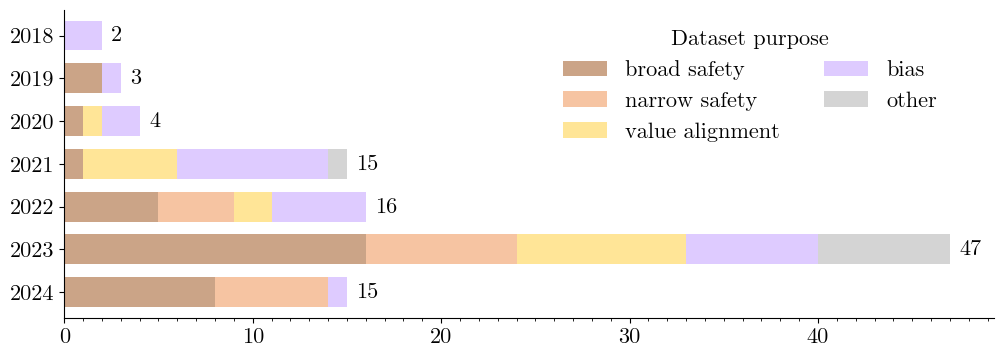

In [10]:
def plot_variable_by_year(df, variable, title=None, col_dict=None):
    
    plot_df = df.groupby("publication_year")[variable].value_counts().unstack()

    if col_dict:
        plot_df = plot_df[col_dict.keys()]

    # reverse rows
    plot_df = plot_df.iloc[::-1]

    # plot
    ax = plot_df.plot(kind="barh", stacked=True, figsize=(12, 4), width=0.7, color=[col_dict[i] for i in plot_df.columns] if col_dict else None)

    # write total length of each bar on the right side
    for i in range(len(plot_df)):
        total = plot_df.iloc[i].sum()
        ax.text(total + 0.5, i, int(total), va='center', weight='bold')

    # set minor ticks on x axis with every 1 
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    # remove top and right spine
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # remove y axis title
    plt.ylabel("")

    # set legend title
    plt.legend(title=title if title else variable, ncol=2, bbox_to_anchor=(0.96, 1), frameon=False)

    plt.savefig("plots/year_" + variable + ".png", bbox_inches="tight")
    
    plt.show()

    return

plot_variable_by_year(df, "purpose_type", title="Dataset purpose", col_dict={"broad safety": "#cba487", "narrow safety": "#f6c4a2", "value alignment": "#ffcc3180", "bias": "#decbff", "other": "#d4d4d4"})

In [11]:
def sort_bucket_size(entries_n):
    if entries_n < 100:
        return "0-100"
    if entries_n < 1000:
        return "100-1000"
    if entries_n < 10000:
        return "1000-10000"
    if entries_n < 100000:
        return "10000-100000"
    if entries_n < 1000000:
        return "100000-1000000"
    return "1000000+"

df["entries_n"] = df["entries_n"].apply(lambda x: int(x.replace(",", "")))
df["entries_n_bucket"] = df["entries_n"].apply(sort_bucket_size)

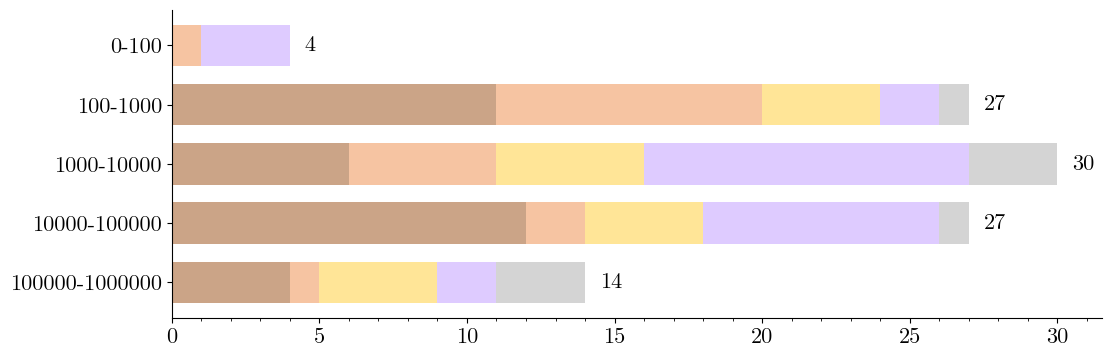

In [12]:
def plot_variable_by_size(df, variable, title=None, col_dict=None):
    
    plot_df = df.groupby("entries_n_bucket")[variable].value_counts().unstack()

    if col_dict:
        plot_df = plot_df[col_dict.keys()]

    # reverse rows
    plot_df = plot_df.iloc[::-1]

    # plot
    ax = plot_df.plot(kind="barh", stacked=True, figsize=(12, 4), width=0.7, color=[col_dict[i] for i in plot_df.columns] if col_dict else None)

    # write total length of each bar on the right side
    for i in range(len(plot_df)):
        total = plot_df.iloc[i].sum()
        ax.text(total + 0.5, i, int(total), va='center', weight='bold')

    # set minor ticks on x axis with every 1 
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    # remove top and right spine
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # remove y axis title
    plt.ylabel("")

    # remove legend
    plt.legend().remove()

    plt.savefig("plots/size_" + variable + ".png", bbox_inches="tight")
    
    plt.show()

    return

plot_variable_by_size(df, "purpose_type", title="Dataset purpose", col_dict={"broad safety": "#cba487", "narrow safety": "#f6c4a2", "value alignment": "#ffcc3180", "bias": "#decbff", "other": "#d4d4d4"})